<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L03_example_robust_portfolio_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SIMPLE PORTFOLIO EXAMPLE FROM "The Price of Robustess"

Modified by:
 1. Melvyn   (Created for ROME, 10 Sep 2009)
 2. Erick Delage (Modified 14 April 2015)
 3. Erick Delage (Adapted to RSOME in November 2020)
 4. Roberto Rocchetta (Adapted Jan 2025)
As discussed in example 1.2 of the  [lecture notes](http://tintin.hec.ca/pages/erick.delage/MATH80624_LectureNotes.pdf) of MATH80624 at HEC Montréal.

WARNING!!!

The following code exploits a free Mosek licence. If you have error messages informing you about licencing issues, you may try uncommenting the installation lines for Gurobi.Otherwise, we recommend that you obtain your own licence of either Mosek ([url](https://www.mosek.com/)) or Gurobi ([url](https://www.gurobi.com/)).

# **Preliminaries**



1. `!pip install rsome`  
   - Installs **RSOME**, a robust stochastic optimization modeling environment.

2. `!pip install mosek`  
   - Installs **MOSEK**, a solver for optimization problems.

3. `!rm mosek.lic`  
   - Removes any existing MOSEK license file (if present).

4. `!git clone https://github.com/roberock/mosek_lic`  
   - Clones a GitHub repository containing a MOSEK license file.

5. `!cp ./mosek_lic/mosek.lic .`  
   - Copies the license file to the current directory.

6. `!rm -r ./mosek_lic`  
   - Deletes the cloned repository after extracting the license.

7. `!mkdir -p /root/mosek`  
   - Creates a directory for MOSEK in the system’s root folder.

8. `!cp ./mosek.lic /root/mosek`  
   - Copies the MOSEK license file to the required directory.

9. `#!pip install -i https://pypi.gurobi.com gurobipy`  
   - (Commented out) Would install **Gurobi**, another solver, if needed.

This setup ensures that **RSOME** and **MOSEK** are installed and properly licensed for optimization tasks. 🚀



In [3]:
!pip install rsome
!pip install mosek
!rm mosek.lic
!git clone https://github.com/roberock/mosek_lic
!cp ./mosek_lic/mosek.lic .
!rm -r ./mosek_lic
!mkdir -p /root/mosek
!cp ./mosek.lic /root/mosek
#!pip install -i https://pypi.gurobi.com gurobipy

Cloning into 'mosek_lic'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [5]:
import rsome as rso
import numpy as np  # Import numpy solver as np
from rsome import ro  # Import ro from rsome (with various functionality)
from rsome import msk_solver as my_solver  #Import Mosek solver interface
#from rsome import grb_solver as my_solver  #Import Gurobi solver interface

# **Simple Portfolio Example**

In [6]:
# Parameter setup
n = 150                                     # Number of stocks
i = np.arange(1, n+1)                       # Indices of stocks
mu =0.15 + i*0.05/150                       # Mean returns
sigma = 0.05/450 * (2*i*n*(n+1))**0.5       # Standard deviations of returns
Gamma = 4                                   # Maximum number of estimates that might deviate

mean returns for the firt 2 stocks: [0.15033333 0.15066667]
standard deviation of the returns: [0.02364866 0.03344426]


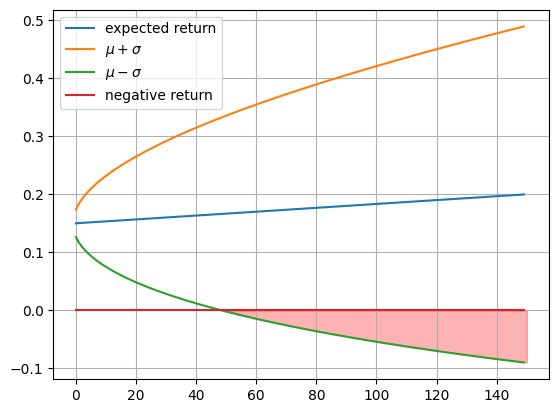

In [68]:
# prompt: print(f'mean returns for the firt 2 stocks: {mu[:2]}')
# print(f'standard deviation of the returns: {sigma[:2]}')
# plt.plot(mu, label = 'expected return')
# plt.plot(mu + sigma, label = 'mu + sigma')
# plt.plot(mu - sigma, label = 'mu - sigma')
# plt.plot(mu*0, label = 'negative return')
# plt.legend()
# fill the negative y<0

import matplotlib.pyplot as plt
plt.fill_between(i, 0, mu - sigma, where=(mu - sigma) < 0, color='red', alpha=0.3, interpolate=True) # fill for risky investments
plt.plot(mu, label = 'expected return')
plt.plot(mu + sigma, label = '$\mu + \sigma$')
plt.plot(mu - sigma, label = '$\mu - \sigma$')
plt.plot(mu*0, label = 'negative return')

plt.xlabel('Stocks')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()


## **Solving a deterministic model**

We consider a portfolio construction problem consisting of $n$ stocks. We consider that stock $i$ has future return $r_i$ and are looking for the portfolio composition that will maximize total return on our investment. This can be done by solving the following linear program:
\begin{align}
\max\limits_{a \in \mathbb{R}^n} \;\;&\sum\limits_{i=1}^n r_ia_i \\
\text{subject to}\; & \sum\limits_{i=1}^n a_i =100\% \\
                    & a_i \geq 0, \forall i=1,\cdots,n,
\end{align}
where $a_i$ is the proportion of the budget invested in stock $i$ (our actions), the first constraint implies that we wish that all the budget be invested, and where $a_i\geq0$ implies that we wish to avoid short selling a stock.

In [15]:
#Create portfolio model
model = ro.Model('portfolio')

#Portfolio weights
a = model.dvar(n)                           # Fractions of investment

# Objective to maximize the return
model.max(mu@a.T)

# Constraint to invest all the wealth available
model.st(a.sum() == 1)                      # Summation of x is one
# Constraint that weights are positive
model.st(a >= 0)                            # x is non-negative

model.solve(my_solver)
optobj_det = model.get() #get optimal objective value
xx_det   = a.get() #get optimal portfolio

print('Deterministic solution: Expected performance of ',np.round(100*optobj_det,2),'% in return')


Being solved by Mosek...
Solution status: Optimal
Running time: 0.0013s
Deterministic solution: Expected performance of  20.0 % in return


## **Evaluating the worst-case return**

In reality, we would need to consider that there is uncertainty about the return obtained from stock $i$. We call this uncertain return $\tilde{r}_i$ and characterize it using
$$\tilde{r}_i = \mu_i+\sigma_i u_i,$$
where $\mu_i$ is the expected return, and $\sigma_i$ describes the volatility of the return, finally $z_i$ captures the source of the uncertainty about $\tilde{r}_i$. You may for example, think of each $z_i$ as being independently distributed according to a standard normal distribution. We will consider the following, problem instance with $n = 150$:
$$\mu_i = 0.15+ i\frac{0.05}{150},\;\;\; \sigma_i = \frac{0.05}{450}\sqrt{2in(n+1)},\;\;\; u_i \in [-1, 1].$$

We can also quantify our tolerance toward risk by assuming that at most $\Gamma$ number of stocks will have their return diverge from their expected value. By controlling the value of $\Gamma$, one can capture the idea that he is more or less risk averse.

Next, given the optimal proportion of deterministic model (denoted by $x^{\text{det}}_i$), we could attempt to optimize the worst-case return vector by solving the following problem:
\begin{align}
\min\limits_{u \in \mathbb{R}}\;\;&\sum\limits_{i=1}^n ( \mu_i+\sigma_i u_i)a^{\text{det}}_i \\
\text{subject to}\; & |u_i| \leq 1 && \forall i=1,\cdots,n \\
                    & \sum\limits_{i=1}^{n}|u_i| \leq \Gamma.
                    %& u_i \in \mathbb{R} &&\forall i=1,\cdots,n.
\end{align}

In [10]:
model = ro.Model('worstcaseReturn')

#Optimize the worst-case return vector
u = model.dvar(n) # Portfolo returns
model.min((mu+sigma*u)@xx_det);  # Objective to minimize the expected return
model.st(u<=1); #each parameter is between [-1, 1]
model.st(u>=-1)
model.st(rso.norm(u,1)<=Gamma)  # sum of absolute deviation smaller than Gamma

model.solve(my_solver); # solve the model
wc_det = model.get()
wc_z_det   = u.get()
print('Deterministic solution: Worst-case performance of ',np.round(100*wc_det,2),'% in return')


Being solved by Mosek...
Solution status: Optimal
Running time: 0.0105s
Deterministic solution: Worst-case performance of  -8.96 % in return


## **Solving a robust model**

Alternatively, we could attempt to solve the following robust optimization problem that only worries about the worst-case return:
\begin{align}
\max\limits_{a \in \mathbb{R}^n} \min\limits_{u \in \mathcal{U}}\;\;&\sum\limits_{i=1}^n ( \mu_i+\sigma_i u_i)a_i \\
\text{subject to}\; & \sum\limits_{i=1}^n a_i =100\% \\
                    & a_i \geq 0, \forall i=1,\cdots,n,
\end{align}
where the budget uncertainty set $\mathcal{U}:=\{u \in \mathbb{R}\;|\;|u_i| \leq 1, \sum_{i}|u
_i| \leq \Gamma\}$.

In [86]:
# create a model
model = ro.Model('robustPortfolio')

# Declare uncertain parameters
u = model.rvar(n)  # Uncertain variables
budgetSet = (u<=1, u>=-1,  #each parameter is between [-1, 1]
                  rso.norm(u,1)<=Gamma);   # Budget of uncertainty approach

# Portfolio weights
a=model.dvar(n);

# Objective to maximize the return
model.maxmin((mu+sigma*u)@a,budgetSet);
# Note that the return r is uncertain and affected by u.
# The objective should be interpreted as
# max{y : y<= (mu + sigma.*u)'a for u in uncertainty set}

# Constraint to invest all the wealth available
model.st(a.sum()==1);
# Constraint that weights are positive
model.st(a>=0);

# solve the model
model.solve(my_solver);
optobj_rob = model.get() #get optimal objective value
xx_rob   = a.get() #get optimal portfolio

print('Robust solution: Expected performance of ',np.round(mu@xx_rob*100,2),'% in return');

print('Robust solution: Worst-case performance of ',np.round(optobj_rob*100,2),'% in return')

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0108s
Robust solution: Expected performance of  18.62 % in return
Robust solution: Worst-case performance of  17.38 % in return


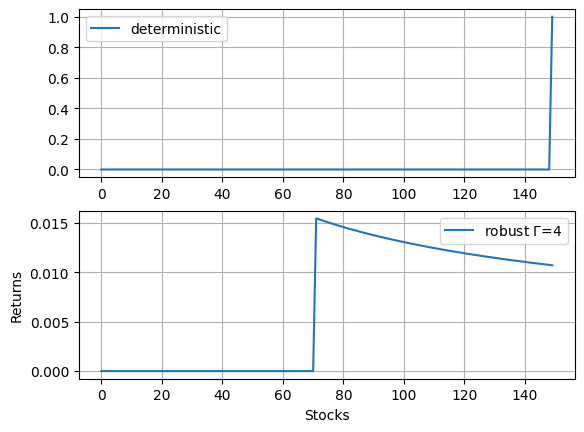

In [89]:
import matplotlib.pyplot as plt
fig, ax =  plt.subplots(2,1)
ax[0].plot(xx_det)
ax[1].plot(xx_rob)
ax[0].grid()
ax[1].grid()
ax[0].legend(['deterministic'])
ax[1].legend([f'robust $\Gamma$={Gamma}'])
plt.xlabel('Stocks')
plt.ylabel('Returns')
plt.show()

In [102]:
## Prepare a function to solve the problem for different values of gamma

def solve_for_given_uncertainty_budget(gamma):

  model = ro.Model('robustPortfolio_gamma_i')  # create a model
  # Declare uncertain parameters
  u = model.rvar(n)  # Uncertain variables
  budgetSet = (u<=1,
               u>=-1,  # each parameter is between [-1, 1]
               rso.norm(u,1)<=gamma) # Budget of uncertainty approach

  a=model.dvar(n)     # Portfolio weights
  model.maxmin((mu+sigma*u)@a,budgetSet)     # Objective to maximize the return
  model.st(a.sum()==1)     # Constraint to invest all the wealth available
  model.st(a>=0)     # Constraint that weights are positive


  model.solve(my_solver)  # solve the model
  optobj_rob = model.get() # get optimal objective value
  xx_rob   = a.get() # get optimal portfolio
  return optobj_rob, xx_rob

In [113]:
## NOW SOLVE FOR DIFFERENT GAMMA VALUES
gamma_values = [0.1, 1, 2, 3, 4, 5, 10, 20 ,30, 50]

# prepare some lists to save the results
expected_performances = []
worst_case_performace = []
xx_rob_list = []

for gamma_i in gamma_values: # loop over uncertainty budget values

  optobj_rob_i, xx_rob_i = solve_for_given_uncertainty_budget(gamma= gamma_i)

  # We are appending (saving) the results to the lists
  xx_rob_list.append(xx_rob_i)
  expected_performances.append(np.round(mu@xx_rob_i*100,2))
  worst_case_performace.append(np.round(optobj_rob_i*100,2))

  # monitor progress by printing the results
  print('Uncertainty budget Gamma : = ', gamma_i)
  print('Robust solution: Expected performance of ',np.round(mu@xx_rob_i*100,2),'% in return');
  print('Robust solution: Worst-case performance of ',np.round(optobj_rob_i*100,2),'% in return')

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0170s
Uncertainty budget Gamma : =  0.1
Robust solution: Expected performance of  19.8 % in return
Robust solution: Worst-case performance of  19.58 % in return
Being solved by Mosek...
Solution status: Optimal
Running time: 0.0097s
Uncertainty budget Gamma : =  1
Robust solution: Expected performance of  19.32 % in return
Robust solution: Worst-case performance of  18.66 % in return
Being solved by Mosek...
Solution status: Optimal
Running time: 0.0122s
Uncertainty budget Gamma : =  2
Robust solution: Expected performance of  19.03 % in return
Robust solution: Worst-case performance of  18.12 % in return
Being solved by Mosek...
Solution status: Optimal
Running time: 0.0116s
Uncertainty budget Gamma : =  3
Robust solution: Expected performance of  18.81 % in return
Robust solution: Worst-case performance of  17.71 % in return
Being solved by Mosek...
Solution status: Optimal
Running time: 0.0104s
Uncertainty budget Gamm

## Interpreting the Results Practically  

- If risk tolerance is high, a lower $\Gamma$ provides a better expected return.  

- If a more stable and robust solution is needed, a higher $ \Gamma $ ensures that even in the worst case, the returns do not drop too much.  


- **Small $\Gamma$** → Higher expected return but riskier in the worst-case.  
- **Large $\Gamma$** → Lower expected return but better worst-case protection.



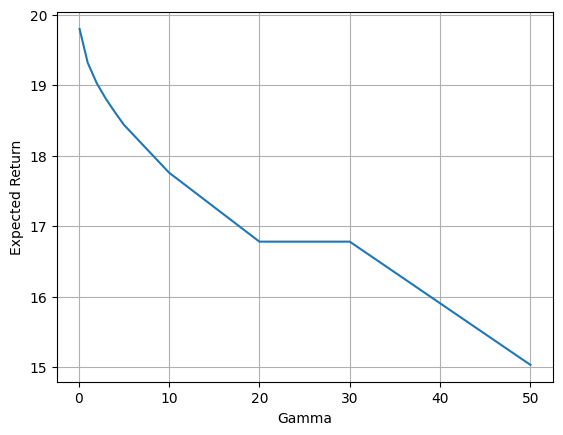

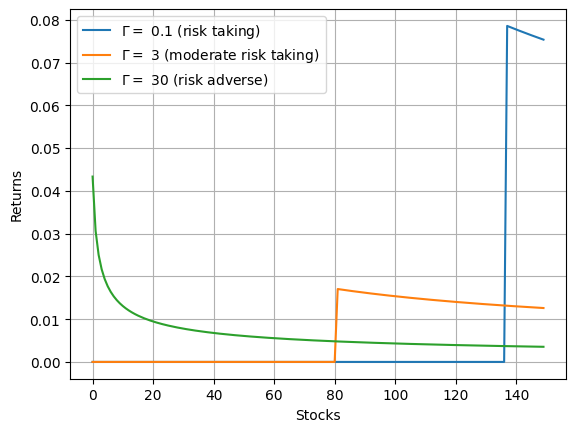

In [117]:
# show the expected performance
plt.plot(gamma_values, expected_performances)
plt.grid()
plt.xlabel('Gamma')
plt.ylabel('Expected Return')
plt.show()

# create a model
plt.plot(xx_rob_list[0], label = f'$\Gamma =$ {gamma_values[0]} (risk taking)')
plt.plot(xx_rob_list[3], label = f'$\Gamma =$ {gamma_values[3]} (moderate risk taking)')
plt.plot(xx_rob_list[-2], label = f'$\Gamma =$ {gamma_values[-2]} (risk adverse)')
plt.legend()
plt.xlabel('Stocks')
plt.ylabel('Returns')
plt.grid()
plt.show()
